### Description
The "Natural Language Processing with Disaster Tweets" Kaggle competition was a data science challenge that tasked participants with developing machine learning models to classify tweets as either referring to real disasters or not. It highlighted the importance of natural language processing (NLP) techniques in analyzing unstructured text data and solving real-world problems. Participants used a variety of approaches, from traditional methods to advanced transformer models like BERT, to achieve high-performing models. The competition emphasized data preprocessing, feature engineering, and model evaluation, and it fostered collaboration and knowledge sharing within the data science community. Overall, it showcased the versatility of NLP and its applications in disaster response and management.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
!pip install text_hammer
import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
#%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from transformers import AutoTokenizer,TFBertModel

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from nltk.corpus import stopwords
from wordcloud import WordCloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.


### Loading The Data

In [3]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('../input/nlp-getting-started/test.csv',usecols=['id','text'])
sample_data = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [6]:
test_data.head()


,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
test_data.tail()


,id,text
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,#CityofCalgary has activated its Municipal Eme...


In [8]:
train_data.head()


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
train_data.tail()

,id,text,target
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1
7612,10873,The Latest: More Homes Razed by Northern Calif...,1


In [10]:
train_data.shape


(7613, 3)

In [11]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [12]:
train_cleaned_data = text_preprocessing(train_data,'text')


  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [13]:
train_cleaned_data[train_cleaned_data.target == 0]


,id,text,target
15,23,whats up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0
...,...,...,...
7581,10833,engineshed great atmosphere at the british lio...,0
7582,10834,cramer igers 3 words that wrecked disneys stoc...,0
7584,10837,these boxes are ready to explode exploding kit...,0
7587,10841,sirens everywhere,0


In [14]:
train_data = train_cleaned_data.copy()


In [15]:
train_data.head(10)


,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,im on top of the hill and i can see a fire in ...,1
8,14,theres an emergency evacuation happening now i...,1
9,15,im afraid that the tornado is coming to our area,1


Here,
* Target 1 indicates any accident or disaster
* Target 0 indicates a formal tweets with not much attention

### Word Cloud:

In [16]:
stop_words = set(stopwords.words('english'))
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

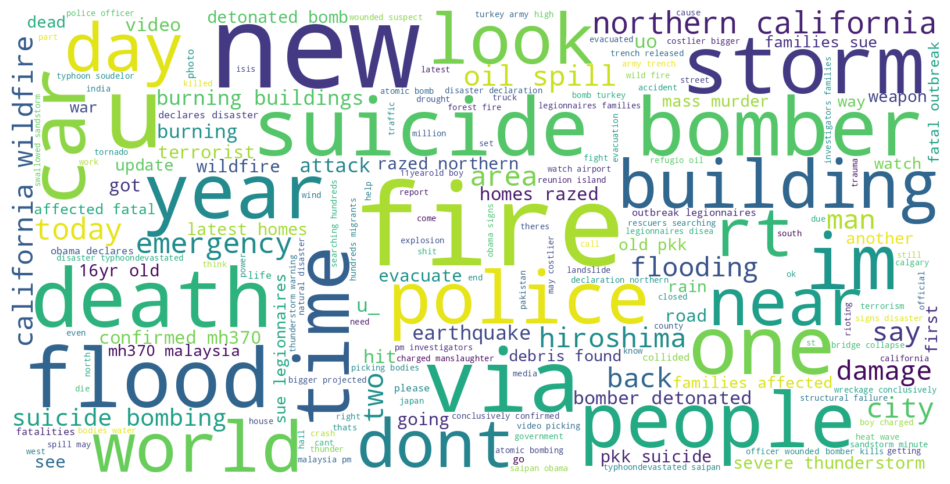

In [18]:
#Disaster Tweets wordcloud 
disaster_tweets = train_data[train_data.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

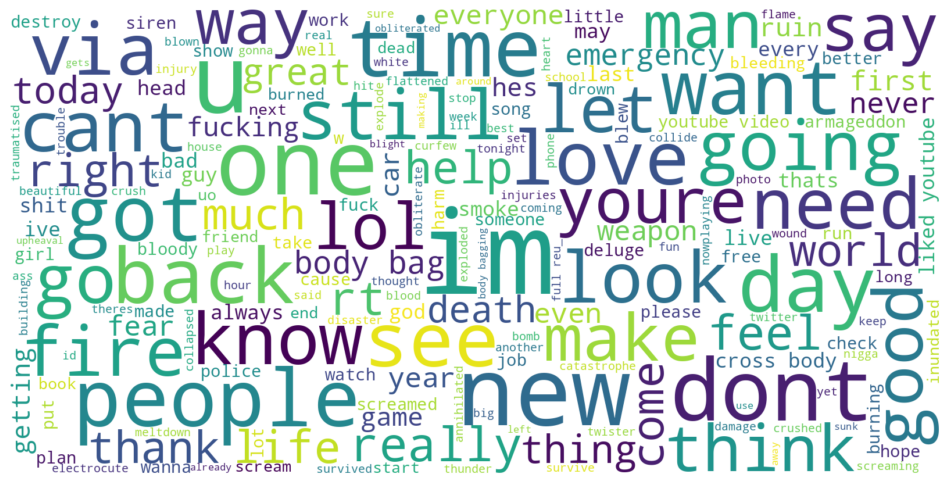

In [20]:
# Positive tweets wordcloud
formal_tweets = train_data[train_data.target == 0]
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

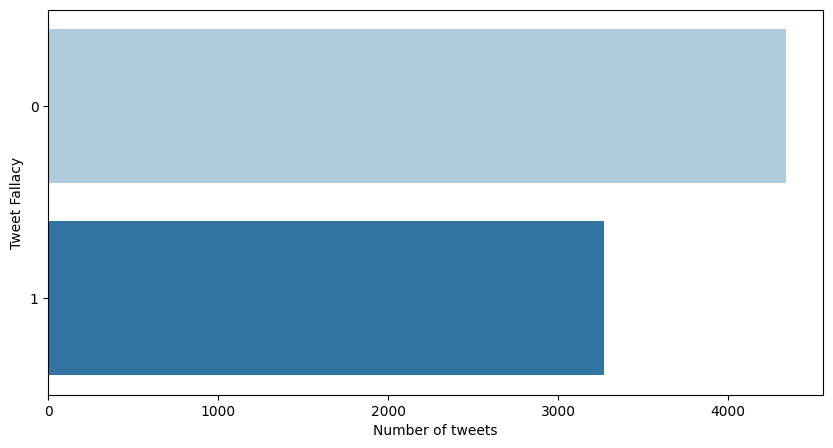

In [21]:
#Visualizing class distribution 
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data,palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of tweets")
plt.show()

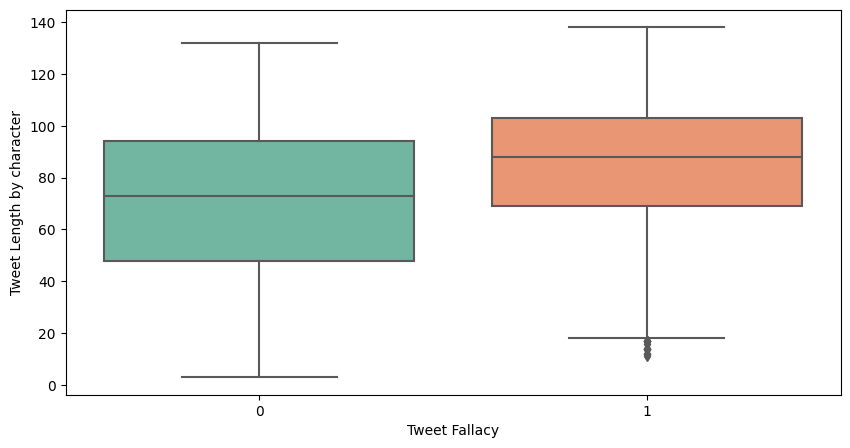

In [22]:
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set2")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

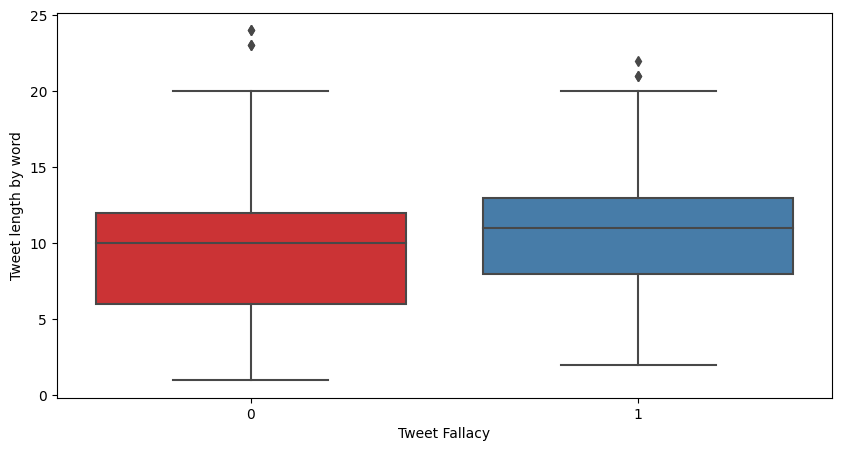

In [23]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

In [24]:
# word_count
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_data['url_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data['mean_word_length'] = train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['text'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['text'].apply(lambda x: len(str(x)))

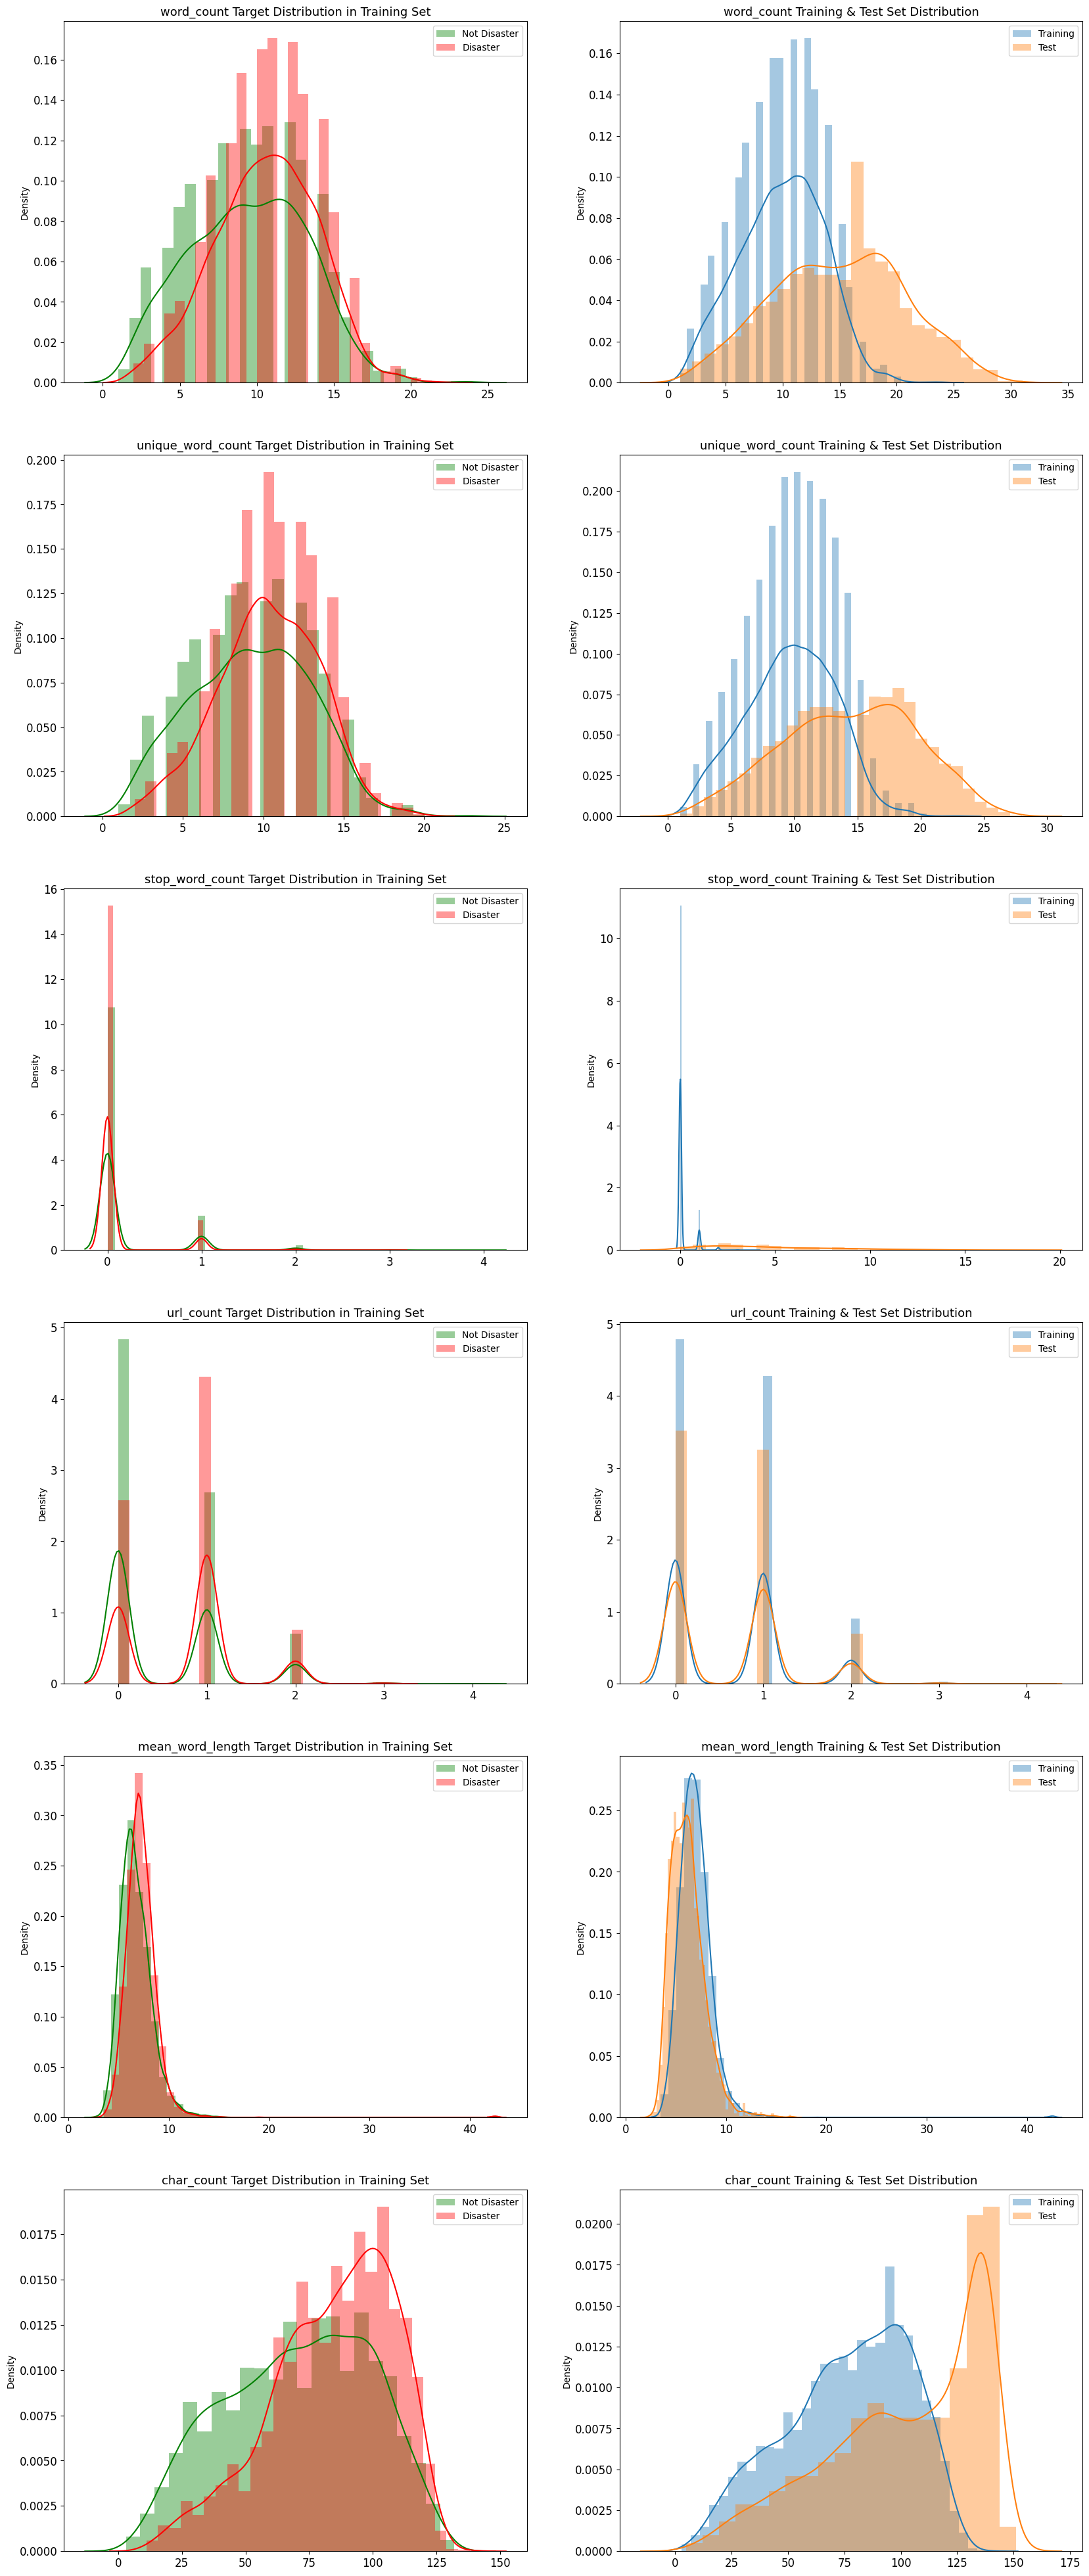

In [25]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train_data['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

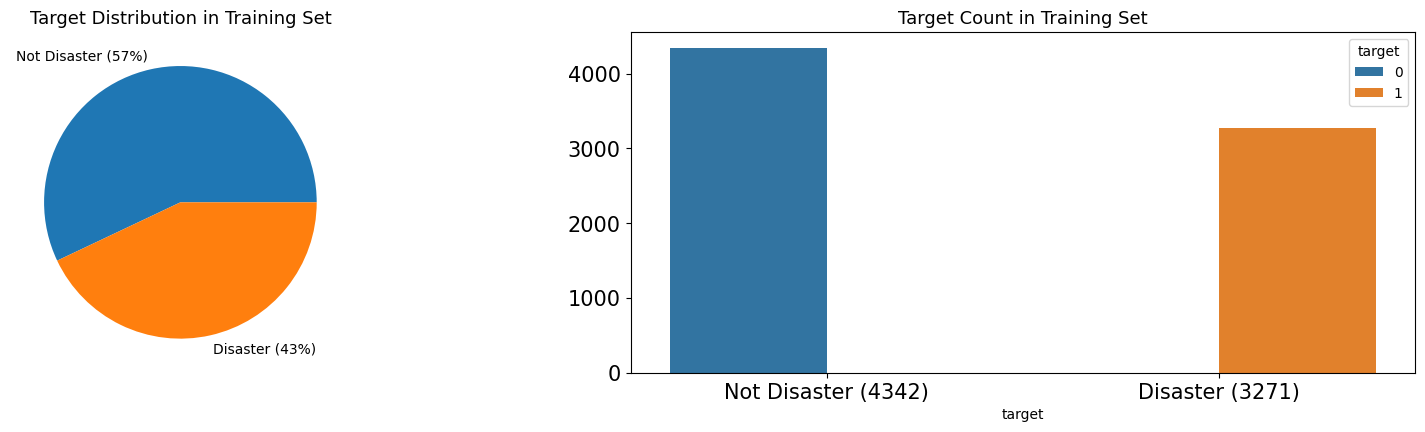

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

BERT - Bidirectional Encoder Representations from Transformers

* BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

* The best part about BERT is that we can use the BERT models to extract high quality language features from our text data.

### LOADING THE BERT MODEL:



In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

In [30]:
tokenizer('Happy learning and keep kaggling &*&*&&')


{'input_ids': [101, 3407, 4083, 1998, 2562, 10556, 13871, 2989, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### CONVERSION OF OUR TEXT DATA INTO BERT INPUT FORMAT:



In [31]:
print("max len of tweets",max([len(x.split()) for x in train_data.text]))
max_length = 36

max len of tweets 24


In [32]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [33]:
x_train['input_ids'].shape


TensorShape([7613, 36])

In [34]:
x_train['attention_mask'].shape


TensorShape([7613, 36])

In [35]:
y_train = train_data.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [36]:
train_data.target.value_counts()


target
0    4342
1    3271
Name: count, dtype: int64

### BUILDING THE MODEL ARCHITECTURE:



In [37]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

# for training bert our lr must be so small

In [38]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                            

In [ ]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

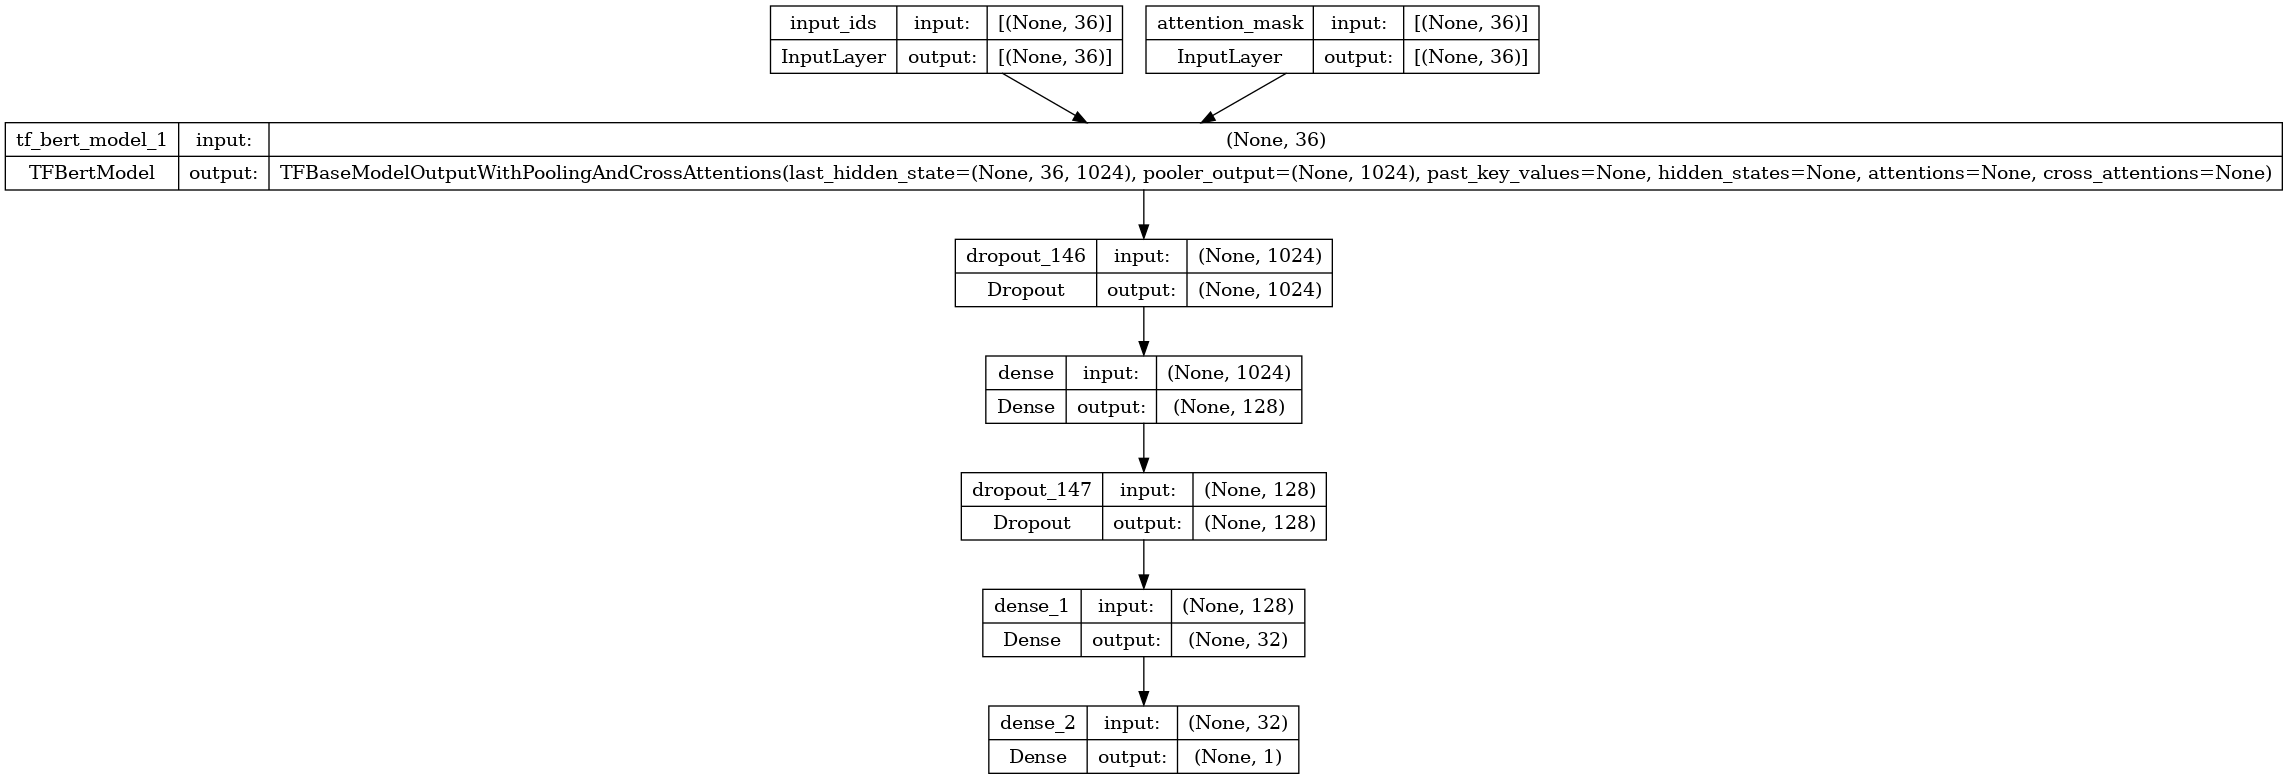

In [41]:
plot_model(model, show_shapes = True)


In [ ]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=9,
    batch_size=10
)

Epoch 1/9
762/762 [==============================] - 215s 233ms/step - loss: 0.5084 - accuracy: 0.7644
Epoch 2/9
762/762 [==============================] - 178s 234ms/step - loss: 0.4231 - accuracy: 0.8235
Epoch 3/9
762/762 [==============================] - 178s 234ms/step - loss: 0.4058 - accuracy: 0.8382
Epoch 4/9
762/762 [==============================] - 179s 234ms/step - loss: 0.4004 - accuracy: 0.8394
Epoch 5/9
762/762 [==============================] - 179s 235ms/step - loss: 0.3897 - accuracy: 0.8400
Epoch 6/9
762/762 [==============================] - 179s 235ms/step - loss: 0.3862 - accuracy: 0.8449
Epoch 7/9
762/762 [==============================] - 179s 235ms/step - loss: 0.3809 - accuracy: 0.8501
Epoch 8/9
762/762 [==============================] - 180s 237ms/step - loss: 0.3788 - accuracy: 0.8487
Epoch 9/9
762/762 [==============================] - 179s 235ms/step - loss: 0.3695 - accuracy: 0.8550

### VISUALIZATION OF LOSS AND ACCURACY CURVE:



In [49]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']
    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [50]:
test_data


,id,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,0,Just happened a terrible car crash,6,6,2,0,4.833333,34
1,2,"Heard about #earthquake is different cities, s...",9,9,2,0,6.222222,64
2,3,"there is a forest fire at spot pond, geese are...",19,19,10,0,4.105263,96
3,9,Apocalypse lighting. #Spokane #wildfires,4,4,0,0,9.250000,40
4,11,Typhoon Soudelor kills 28 in China and Taiwan,8,8,2,0,4.750000,45
...,...,...,...,...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,8,7,0,0,6.000000,55
3259,10865,Storm in RI worse than last hurricane. My city...,23,22,7,0,5.086957,139
3260,10868,Green Line derailment in Chicago http://t.co/U...,6,6,1,1,8.333333,55
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,7,7,0,1,8.428571,65


In [51]:
x_test = tokenizer(
    text=test_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

### PREDICTION:



In [52]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

102/102 [==============================] - 615s 6s/step


In [53]:
y_predicted = np.where(predicted>0.5,1,0)

In [54]:
y_predicted = y_predicted.reshape((1,3263))[0]


In [55]:
sample_data.head()


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [56]:
sample_data.to_csv('submission.csv',index = False)
print(" Successfully completed! ")

 Successfully completed! 


### Conclusion
In conclusion, the "Natural Language Processing with Disaster Tweets" Kaggle competition has been a remarkable journey into the world of text analysis and machine learning. This competition provided a platform for data scientists, researchers, and enthusiasts from around the world to come together and tackle a critical problem: identifying tweets that refer to real disasters. As we reflect on this competition, several key takeaways and observations come to the forefront.

Firstly, the competition underscored the significance of natural language processing (NLP) techniques in addressing real-world challenges. NLP has the potential to extract valuable insights from unstructured textual data, and this competition demonstrated its applicability in disaster response and management.

Secondly, the diverse approaches and methodologies used by participants highlighted the versatility of NLP models and techniques. From traditional models like TF-IDF and logistic regression to cutting-edge transformer models like BERT and GPT, the competition showcased the power of innovation and creativity in solving complex NLP tasks.

Furthermore, the competition emphasized the importance of data preprocessing, feature engineering, and model evaluation. Clean and well-structured data, along with thoughtful feature engineering, played a crucial role in achieving high-performing models. Rigorous evaluation metrics such as F1-score and precision-recall curves helped participants fine-tune their models and ensure robust performance.

Lastly, collaboration and knowledge sharing were pivotal in this competition's success. Participants shared their insights, code snippets, and strategies on forums and platforms, contributing to a vibrant and collaborative data science community.

As we move forward from this competition, it is essential to recognize that NLP continues to evolve rapidly. New techniques and models will emerge, further expanding our capabilities in understanding and extracting insights from textual data. The skills and knowledge gained from this competition will undoubtedly prove valuable in addressing various other NLP challenges and real-world applications.

In closing, the "Natural Language Processing with Disaster Tweets" Kaggle competition not only pushed the boundaries of NLP but also brought together a community of data enthusiasts dedicated to making a positive impact. It serves as a testament to the power of data science and collaborative problem-solving in addressing critical global issues.